# Health insurance cross sell prediction with XGBoost

## 1. Problem description

[Kaggle source](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction)
This dataset contains a list of health insurance customers. The "Response" column indicates whether the customer also wanted to use car insurance. I'll try to build a model that predicts this decision.

In [1]:
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")


print("Number of rows:", df.shape[0])
df.head()

Number of rows: 381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Initial data visualization
TODO

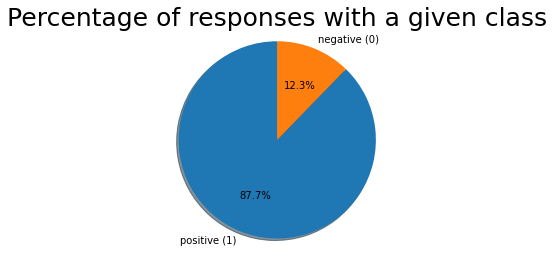

In [2]:
labels = ["positive (1)", "negative (0)"]
negative = df[df.Response == 0].size
positive = df[df.Response == 1].size
sizes = [negative, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of responses with a given class", fontsize=25)
plt.show()

There are much more (87,7%) people witch choose both insurances.

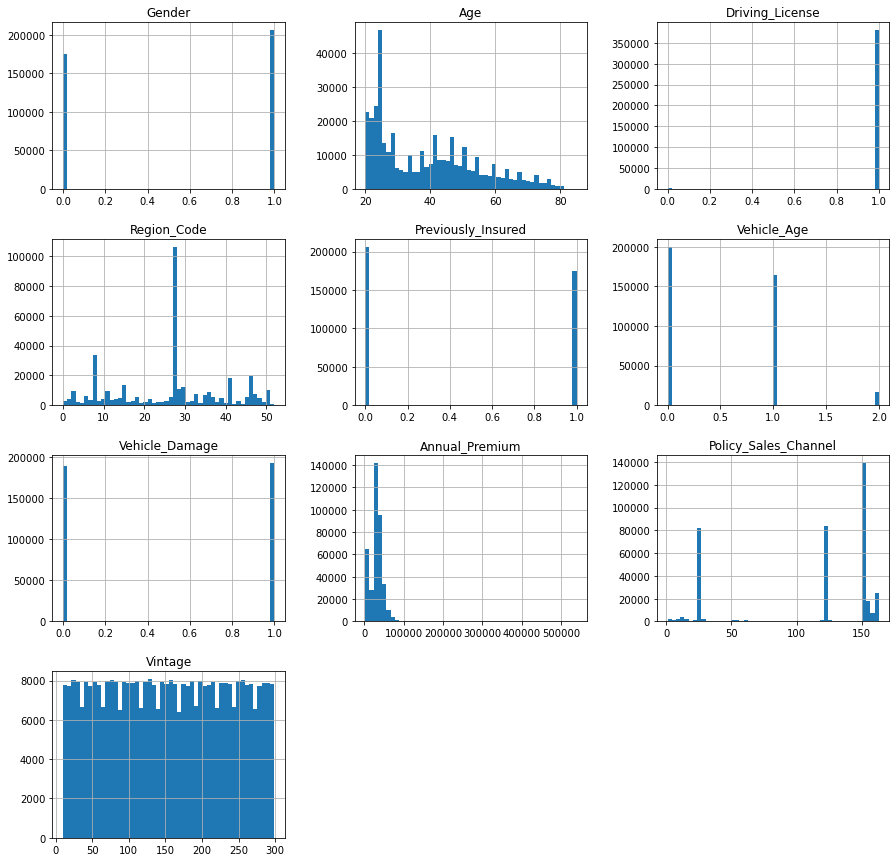

In [3]:
X_le.hist(bins=50, figsize=(15, 15))
plt.show()

TODO: conclusions from histogram

## 3. Basic model with logistic regression
TODO

### 3.1 Metric
TODO: linguistically improve the paragraph
This problem is an example of an "imbalanced dataset". It means that one class ("negative"/"zeroes" in this article) has significantly more samples than the others. You can get 87.7% accuracy... just by assigning the same prediction to all cases. There are more reliable metrics for imbalanced datasets - one of them is ROC AUC.

#### 3.1.1 True positive rate, False positive rate
For proper understanging of ROC AUC metric it is necessary first to explain TPR (true positive rate) and FPR (false positive rate).

True positive rate is number of proper predicted positive cases divided by all positive cases. For example - if there are 10.000 customers which choosed an insurance and our model found 9.500 of them - TPR equals 9.500/10.000 = 95%

False positive rate is number of false predicted positive cases divided by all negative cases. For example - if there are 100.000 customers which didn't choose an insurance and our model predicted that 1.000 of them choosed it - FPR equals 1.000/100.000 = 1%

#### 3.1.2 Receiver operating characteristic
Usually we can set threshold describing how sure the algorithm need to be to predict the result for single sample as "true". There is TPR on vertical axis and FPR on horizontal axis and the ROC curve is created by plotting points for consecutive thresholds.

#### 3.1.3 ROC Area under curve
It could be hard to simple compare various ROC curves. For this purpose I'll use the final metric - ROC AUC (area under curve). The alhorithm will calculate area under ROC curve - it's much easier to compare single numbers.


### 3.2 Cross validation
Cross validation is a way of measuring model performance. It divides all the data into a given number of parts. Later in each iteration, one part is used as validation data and the rest as training data. Each part was used as test data after all iterations. This method gives more reliable measurements than standard one-step validation.

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, n_jobs=-1)
cross_val_summary(logreg, X_le, y)

Cross validation time: 21.34451174736023 seconds
Mean score: 0.6626219144051005


## 4. Simple model with Light GBM
TODO

In [2]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)
cross_val_summary(lgbm, X_le, y)

Cross validation time: 3.715799331665039 seconds
Mean score: 0.8575017665775645


## 5 Remove 'Vintage' column

TODO: add description

In [6]:
cross_val_summary(lgbm, X_le.drop(columns="Vintage"), y, message="Mean ROC_AUC without 'Vintage' column: ")

Cross validation time: 3.272094249725342 seconds
Mean ROC_AUC without 'Vintage' column: 0.8577693288099889


## 6. StandardScaler vs PowerTransformer vs QuantileTransformer

TODO: add description

In [7]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer

# TODO: determine which model returns log about scaling/more iterations
def compare_preprocessing(model, X, y):
    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_scaler = make_pipeline(scaler, model)
    model_transformer = make_pipeline(transformer, model)
    model_scaler_transformer = make_pipeline(scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(quant_trans_normal, model)

    cross_val_summary(model, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

compare_preprocessing(lgbm, X_le.drop(columns="Vintage"), y)

Cross validation time: 3.299079179763794 seconds
Mean ROC_AUC score without scaler: 0.8577693288099889
Cross validation time: 3.50941801071167 seconds
Mean ROC_AUC score with scaler: 0.8574143509437648


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healt

Cross validation time: 19.19187307357788 seconds
Mean ROC_AUC score with transformer: 0.8577319440867275
Cross validation time: 22.24144411087036 seconds
Mean ROC_AUC score with scaler and transformer: 0.8577400779770201
Cross validation time: 5.565432548522949 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576643396361232
Cross validation time: 6.502594232559204 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8576585510190945


The differences between various scaling methods are small, so I need to make more tests after the next steps.

## 8. Policy_Sales_Channel One Hot Encoding

"Policy_Sales_Channel" is a categorical column. Algorithms cannot always effectively use this type of data in a single column. For example, channel 2 is not "smaller" than channel 4, and channel 3 is not "between" them in a mathematical sense. There are some tools addressing this problem. For now I'll use One Hot Encoding. It creates a new column for each of the categories and fills it with 1 if the sample falls into that category and with 0 if it does not.

In [8]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.652437448501587 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 17.13546371459961 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/js

Cross validation time: 299.45684337615967 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_tra

Cross validation time: 414.3436620235443 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 23.52898359298706 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 36.257479190826416 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577135371381092


I checked - it works worse with dropped original Policy_Sales_Channel column

Unfortunately, there are 155 distinct categories. Considering almost 400.000 samples and complex algorithm - this step seriosly slows down training. Additionaly - it generates a lot of column with few "ones" and several hundred thousand "zeros".

How to curb this problem?

If given policy sales channel occurs only once in the whole dataset, it can't be used to predict other samples. At first I will eliminate such categories.

In [9]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.543667793273926 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 16.693971633911133 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/h

Cross validation time: 283.97425365448 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913


/home/jsowa/anaconda3/envs/healtenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Cross validation time: 394.5038664340973 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 22.755218982696533 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 35.103058099746704 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8576189364379558


Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,

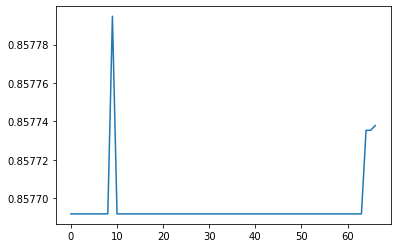

In [64]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores = []

iteration = 0
print('Done iterations: ', end='')
for x in range(147, 1, -1):
    iteration+=1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores += [score]
    print(str(iteration) + ",", end='')

scores_series = pd.Series(scores)
plt.plot(scores_series.index, scores_series.values)

Probably I can easily remove 60 columns without affect on model performance, but I still need to check results for other scalers.

In [4]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

compare_preprocessing(lgbm, X_le_psc.drop(columns=columns_to_remove), y)

Cross validation time: 5.6952736377716064 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 12.071979999542236 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 162.0033049583435 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 218.17398762702942 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 15.900956869125366 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 24.017045259475708 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578170529189757


Results are the same (for QuantileTransformer with normal distribution even better), but training is much faster.

### 8.2 Target encoding on Policy_Sales_Channel

In [ ]:
from category_encoders import TargetEncoder

def compare_preprocessing_te(model, X, y, te_columns):
    encoder = TargetEncoder(cols=te_columns)

    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_te = make_pipeline(encoder, model)
    model_scaler = make_pipeline(encoder, scaler, model)
    model_transformer = make_pipeline(encoder, transformer, model)
    model_scaler_transformer = make_pipeline(encoder, scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(encoder, quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(encoder, quant_trans_normal, model)

    cross_val_summary(model_te, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

In [4]:
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel'])

Cross validation time: 6.895636558532715 seconds
Mean ROC_AUC score without scaler: 0.8578516811768312
Cross validation time: 12.551993131637573 seconds
Mean ROC_AUC score with scaler: 0.8578067917946631
Cross validation time: 162.76739883422852 seconds
Mean ROC_AUC score with transformer: 0.8577500725688326
Cross validation time: 219.64318704605103 seconds
Mean ROC_AUC score with scaler and transformer: 0.857805818285436
Cross validation time: 17.547009229660034 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8577424395726098
Cross validation time: 24.262820720672607 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578096972047613


All results except QuantileTransformer with normal distribution are higher.

I checked - result without original Policy_Sales_Channel column are worse.

## 9. TargetEncoding on Region_Code

Without original Region_Code column:

In [5]:
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.385013580322266 seconds
Mean ROC_AUC score without scaler: 0.8578672559914619
Cross validation time: 12.798346519470215 seconds
Mean ROC_AUC score with scaler: 0.8580431893748506
Cross validation time: 163.73356127738953 seconds
Mean ROC_AUC score with transformer: 0.8580417526017181
Cross validation time: 218.94549584388733 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580898524585432
Cross validation time: 17.591765880584717 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.858124605199893
Cross validation time: 24.033880710601807 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8579435208664062


With original Region_Code column:

In [6]:
X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']

compare_preprocessing_te(lgbm, X_le_psc_te_rc, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.1955201625823975 seconds
Mean ROC_AUC score without scaler: 0.8582197639563397
Cross validation time: 12.822477102279663 seconds
Mean ROC_AUC score with scaler: 0.8581328309025407
Cross validation time: 163.78668522834778 seconds
Mean ROC_AUC score with transformer: 0.8583319013615907
Cross validation time: 221.69700169563293 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580616992741815
Cross validation time: 18.147982358932495 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8580370579413217
Cross validation time: 24.764060258865356 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8581242602095361


Version with PowerTransformer and additional, original column 'Region_Code' returns best result, so I'll choose this one for next analyses.

# 10. Feature selection

In [1]:
# TODO: remove this cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']

In [2]:
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 0
cycle_score = None
X_final = X_le_psc_te_rc
fixed_columns = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel', 'Policy_Sales_Channel_te', 'Region_Code_te']
columns_to_remove = []
columns_to_remove_len_before_cycle = 0

while True:
    full_cycle_iter += 1
    columns_to_remove_len_before_cycle = len(columns_to_remove)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in X_final.drop(columns=columns_to_remove).columns.values if col not in fixed_columns]
    base_score = cross_val_score(model, X_final.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_without_column = cross_val_score(model, X_final.drop(columns=columns_to_remove+[column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_without_column >= base_score:
            base_score = score_without_column
            columns_to_remove += [column]
    if columns_to_remove_len_before_cycle == len(columns_to_remove):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_remove).to_csv('results/columns_to_remov' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_remove)) + " columns was removed")

Starting full cycle number 1
Calculated base score: 0.8583319026420148
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

36,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

38,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

39,40,41,42,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

64,65,66,67,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

68,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

69,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

70,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

71,72,73,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

74,75,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

76,77,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

78,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

79,80,81,82,83,84,85,86,87,
Score after 1 cycle: 0.8583499969560096
42 columns was removed
Starting full cycle number 2
Calculated base score: 0.8583499969560096
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

15,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

16,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

17,18,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

21,22,23,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

24,25,26,27,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

28,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,
Score after 2 cycle: 0.8583605770849971
47 columns was removed
Starting full cycle number 3
Calculated base score: 0.8583605770849971
Finished iterations: 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

1,2,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

3,4,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

5,6,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

7,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

8,9,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

10,11,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

12,13,14,15,16,17,18,19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

21,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

22,23,24,25,26,27,28,29,30,31,32,33,34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

36,37,38,39,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

40,
Score after 3 cycle: 0.8583761424194671
50 columns was removed
Starting full cycle number 4
Calculated base score: 0.8583761424194671
Finished iterations: 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

1,2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

4,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

5,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

6,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

7,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

8,9,10,11,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

12,13,14,15,16,17,18,19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

21,22,23,24,25,26,27,28,29,30,31,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

36,37,
Score after 4 cycle: 0.8583790515431551
52 columns was removed
Starting full cycle number 5
Calculated base score: 0.8583790515431551
Finished iterations: 1,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

4,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

5,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

6,7,8,9,10,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

11,12,13,14,15,16,17,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

18,19,20,21,22,23,24,25,26,27,28,29,30,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

31,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

34,35,
No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

In [8]:
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]
X_final.drop(columns=selected_to_remove)
cross_val_summary(model, X_final.drop(columns=selected_to_remove), y)

Cross validation time: 73.4052996635437 seconds
Mean score: 0.8583790502627309


## 12. Region_Code OHE and feature selection

In [14]:
X_le.Region_Code.value_counts()

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Region_Code, dtype: int64

There are no really small categories, but still - the smallest one has 183 samples and the biggest one has over 100k samples

In [15]:
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_rc_ohe, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581446785145823

In [18]:
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

In [19]:
# BACKWARD SELECTION

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 0
cycle_score = None
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_remove = []
columns_to_remove_len_before_cycle = 0

while True:
    full_cycle_iter += 1
    columns_to_remove_len_before_cycle = len(columns_to_remove)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in X_rc_ohe.drop(columns=columns_to_remove).columns.values if col not in fixed_columns]
    print("Number of iters in this cycle: " + str(len(selection_columns)))
    base_score = cross_val_score(model, X_rc_ohe.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_without_column = cross_val_score(model, X_rc_ohe.drop(columns=columns_to_remove+[column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_without_column >= base_score:
            base_score = score_without_column
            columns_to_remove += [column]
    if columns_to_remove_len_before_cycle == len(columns_to_remove):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_remove).to_csv('results/columns_to_remove_rc' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_remove)) + " columns was removed")

Starting full cycle number 1
Number of iters in this cycle: 53
Calculated base score: 0.8581446785145823
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

31,32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

36,37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

38,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

39,40,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

41,42,43,44,45,46,47,48,49,50,51,52,53,
Score after 1 cycle: 0.8583419523630965
7 columns was removed
Starting full cycle number 2
Number of iters in this cycle: 46
Calculated base score: 0.8583419523630965
Finished iterations: 1,2,3,4,5,6,7,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

8,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

9,10,11,12,13,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

14,15,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

16,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

17,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

18,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

21,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

22,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

23,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

24,25,26,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

45,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

46,
Score after 2 cycle: 0.8583419523630965
8 columns was removed
Starting full cycle number 3
Number of iters in this cycle: 45
Calculated base score: 0.8583419523630965
Finished iterations: 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

1,2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

KeyboardInterrupt: 

In [20]:
# FORWARD SELECTION

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 0
cycle_score = None
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = []
columns_to_add_len_before_cycle = 0

while True:
    full_cycle_iter += 1
    columns_to_add_len_before_cycle = len(columns_to_add)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in rc_ohe.columns if col not in fixed_columns and col not in columns_to_add]
    print("Number of iters in this cycle: " + str(len(selection_columns)))
    base_score = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_with_column = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add + [column]], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_with_column >= base_score:
            base_score = score_with_column
            columns_to_add += [column]

    if columns_to_add_len_before_cycle == len(columns_to_add):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_add).to_csv('results/columns_to_add_rc' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_add)) + " columns was added")

Starting full cycle number 1
Number of iters in this cycle: 53
Calculated base score: 0.8583790515431551
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

26,27,28,29,30,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

31,32,33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

36,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

38,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

39,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

40,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

41,42,43,44,45,46,47,48,49,50,51,52,53,
Score after 1 cycle: 0.8583829382706879
4 columns was added
Starting full cycle number 2
Number of iters in this cycle: 49
Calculated base score: 0.8583829382706879
Finished iterations: 1,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

KeyboardInterrupt: 

In [1]:
# TODO: remove this cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

In [2]:
# FORWARD SELECTION step 2
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 1
cycle_score = None
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]
columns_to_add_len_before_cycle = 4

while True:
    full_cycle_iter += 1
    columns_to_add_len_before_cycle = len(columns_to_add)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in rc_ohe.columns if col not in fixed_columns and col not in columns_to_add]
    print("Number of iters in this cycle: " + str(len(selection_columns)))
    base_score = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_with_column = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add + [column]], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_with_column >= base_score:
            base_score = score_with_column
            columns_to_add += [column]

    if columns_to_add_len_before_cycle == len(columns_to_add):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_add).to_csv('results/columns_to_add_rc' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_add)) + " columns was added")

Starting full cycle number 2
Number of iters in this cycle: 49
Calculated base score: 0.8583829382706879
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

29,30,31,32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

36,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

38,39,40,41,42,43,44,45,46,47,48,49,
No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

# Partial PowerTransformer

In [8]:
from sklearn.compose import ColumnTransformer

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])

full_cycle_iter = 0
cycle_score = None
columns_wo_tran_len_before_cycle = 0
columns_without_transformer = []
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

while True:
    all_columns = [x for x in X_reduce_te.columns.values if x not in columns_without_transformer]
    full_cycle_iter += 1
    print("Starting full cycle number " + str(full_cycle_iter))
    print("All columns number: " + str(len(all_columns)))
    columns_wo_tran_len_before_cycle = len(columns_without_transformer)
    transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
    model = make_pipeline(encoder, transformer, lgbm)
    base_score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and whole dataset
    print("Base score: " + str(base_score))
    if cycle_score is None:
        cycle_score = base_score
    counter = 0
    print("Iterations finished: ", end='')
    for column in all_columns:
        columns_for_transformer = [x for x in all_columns if x not in columns_without_transformer + [column]]
        transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)])
        model = make_pipeline(encoder, transformer, lgbm)

        score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()  # TODO: set cv=10 and whole dataset
        counter += 1
        print(str(counter), end='')
    
        if score >= base_score:
            base_score = score
            print("Score for transformer without " + column + " column: " + str(score))
            columns_without_transformer += [column]
    
    if columns_wo_tran_len_before_cycle == len(columns_without_transformer):
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_without_transformer).to_csv('results/columns_without_transformer' + str(full_cycle_iter) + '.csv')
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_without_transformer)) + " columns was removed")
    print()

Starting full cycle number 1
All columns number: 50
Base score: 0.8583829382706879
Iterations finished: 123456789101112131415161718192021222324252627282930

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

3132

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

3738

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

394041

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

42

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

434445

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

4647Score for transformer without Region_Code_0.0 column: 0.8583829382706879
4849Score for transformer without Region_Code_38.0 column: 0.8583829382706879
50Score for transformer without Region_Code_52.0 column: 0.8583829382706879
Score after 1 cycle: 0.8583829382706879
3 columns was removed

Starting full cycle number 2
All columns number: 47
Base score: 0.8583829382706879
Iterations finished: 12345678910111213

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

1415

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

161718

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

19202122

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2324

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

25

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

26

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2728293031

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

32

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

333435363738394041424344454647No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

We have the same score, but model is slightly faster - now it doesn't need to transform 3 columns. It's not a big improvement, but I'll use it for faster tuning.

## TargetEncoding on Vehicle_Age

In [7]:
X_vage_te = X_reduce_te.copy()

transformer_columns = [x for x in X_vage_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code', 'Vehicle_Age'])
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), transformer_columns)])

model = make_pipeline(encoder, transformer, lgbm)
cross_val_score(model, X_vage_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8580166335152419

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

It doesn't improve the result.

## Oversampling/SMOTE

In [1]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

# cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

In [10]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('over', oversample), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581684909994174

In [11]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('enc', encoder), ('over', oversample), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581055667809746

In [12]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('enc', encoder), ('trans', transformer), ('over', oversample), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.858204569951902

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

In [7]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('smt', smote), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8420298085837888

In [8]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('enc', encoder), ('smt', smote), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.840975800838976

In [9]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('enc', encoder), ('trans', transformer), ('smt', smote), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8520831275035989

It didn't improve the result

## LGBM with AUC metric

In [19]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

lgbm = LGBMClassifier(random_state=42, verbose=-1, eval_metric='auc')
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8583829369902638

[12:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

[12:29:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, d

[12:29:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

[12:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.

[12:29:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

[12:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

It didn't improve the result.

## Model tuning

In [1]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

# cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

In [3]:
import optuna
np.seterr(all="ignore")

trials_number = 50 # TODO: set higer value

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 8)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.1, 3.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.1,
        "depth_limit": True,
        "max_depth": 5,
        "num_leaves_pow": 5,
        "n_estimators": 100,
        "subsample": 1.0,
        "class_weight": None,
        "te_smoothing": 1.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-01 15:00:16,639] A new study created in memory with name: no-name-478b758f-5f1b-4557-865c-46add1187cf2


Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 37

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 38, 39, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50
Best trial:
  ROC AUC: 0.858814764670927
  Params: 
    learning_rate: 0.009214155727458158
    depth_limit: False
    num_leaves_pow: 6
    n_estimators: 748
    subsample: 0.7116290449402978
    class_weight: None
    te_smoothing: 0.36043121104209824


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

In [14]:
import optuna
np.seterr(all="ignore")

trials_number = 50 # TODO: set higer value

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 9)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 1500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 3.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.009214155727458158,
        "depth_limit": False,
        "max_depth": 5,
        "num_leaves_pow": 6,
        "n_estimators": 748,
        "subsample": 0.7116290449402978,
        "class_weight": None,
        "te_smoothing": 0.36043121104209824
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-02 10:35:34,108] A new study created in memory with name: no-name-bc7c1e44-33dd-4e9e-a37d-6322b49b66fe


Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

, 32

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 34, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 37

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 38, 39, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 41

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 42, 43, 44, 45, 46, 47, 48, 49, 50
Best trial:
  ROC AUC: 0.8588175241512397
  Params: 
    learning_rate: 0.005017264032393435
    depth_limit: False
    num_leaves_pow: 6
    n_estimators: 1469
    subsample: 0.47151419221112034
    class_weight: None
    te_smoothing: 2.9510219777055813


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

In [3]:
import optuna
np.seterr(all="ignore")

trials_number = 100

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 9)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 2500)
    subsample = trial.suggest_uniform('subsample', 0.3, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 5.0)
    reg_alpha = trial.suggest_uniform("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_uniform("reg_lambda", 0.0, 1.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.005017264032393435,
        "depth_limit": False,
        "max_depth": 5,
        "num_leaves_pow": 6,
        "n_estimators": 1469,
        "subsample": 0.47151419221112034,
        "class_weight": None,
        "te_smoothing": 2.9510219777055813,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 31, 32, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 37, 38

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 39

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 41, 42, 43, 44, 45

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 65, 66

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 67, 68, 69, 70

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 71, 72

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 73

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 74

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 75, 76

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 77, 78

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 79, 80, 81, 82, 83, 84, 85

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 99, 100
Best trial:
  ROC AUC: 0.8588986626649424
  Params: 
    learning_rate: 0.010259408143780216
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 9
    n_estimators: 2371
    subsample: 0.6951379234882272
    class_weight: None
    te_smoothing: 0.6741836510673999
    reg_alpha: 0.163111686021624
    reg_lambda: 0.2639575808284711


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

## XGB model

In [2]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]



In [16]:
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="logloss")
model = make_pipeline(encoder, transformer, xgb)

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8573248290714328

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.

In [17]:
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False)
model = make_pipeline(encoder, transformer, xgb)

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8573248290714328

In [18]:
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric="auc", objective='binary:logistic')
model = make_pipeline(encoder, transformer, xgb)

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8573248290714328

In [2]:
import optuna
np.seterr(all="ignore")

trials_number = 20 # TODO: set higer value

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = 0
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 5.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 6)
    gamma = trial.suggest_uniform("gamma", 0.0, 0.5)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.4, 1.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e2)

    
    xgb = XGBClassifier(random_state=42, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, xgb)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.1,
        "depth_limit": True,
        "max_depth": 3,
        "min_child_weight": 1,
        "n_estimators": 100,
        "subsample": 1.0,
        "class_weight": None,
        "te_smoothing": 1.0,
        "gamma": 0,
        "colsample_bytree": 1.0,
        "reg_alpha": 1.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-04 08:40:22,990] A new study created in memory with name: no-name-228bde8e-5532-415a-b153-fe4c9e5d5936


Finished trials: 1[08:41:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

[08:41:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


, 2, 3, 4[08:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:42] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was change

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[08:41:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:40] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 5, 6, 7

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 8

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 9

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[08:41:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:37] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

[08:44:37] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:59] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 10, 11

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 12

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[09:33:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:38:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:47:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[09:33:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:35:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:47:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 13, 14, 15

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

, 16

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

, 17

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

, 18, 19

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

, 20
Best trial:
  ROC AUC: 0.8589450589430611
  Params: 
    learning_rate: 0.07831763620588078
    depth_limit: True
    max_depth: 7
    n_estimators: 161
    subsample: 0.8843750998824226
    class_weight: None
    te_smoothing: 4.348199158813301
    min_child_weight: 4
    gamma: 0.2074667355919607
    colsample_bytree: 0.558984643852758
    reg_alpha: 0.10306344251488078


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:59:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:02:01] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:02:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:19:37] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[08:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:38] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[08:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:42] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

[10:05:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:39:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[08:41:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:37] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[10:05:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:39:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[08:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:39] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

[08:44:44] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:44:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:59:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

In [7]:
import optuna
np.seterr(all="ignore")

trials_number = 20 # TODO: set higer value

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = 0
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 10.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7)
    gamma = trial.suggest_uniform("gamma", 0.0, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.3, 1.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e2)

    
    xgb = XGBClassifier(random_state=42, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, xgb)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    print("Finished trial number: " + str(trial.number+1))
    print("  ROC AUC: {}".format(score))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.07831763620588078,
        "depth_limit": True,
        "max_depth": 7,
        "min_child_weight": 4,
        "n_estimators": 161,
        "subsample": 0.8843750998824226,
        "class_weight": None,
        "te_smoothing": 4.348199158813301,
        "gamma": 0.2074667355919607,
        "colsample_bytree": 0.558984643852758,
        "reg_alpha": 0.10306344251488078
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[10:14:35] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

[10:14:35] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option us

Finished trial number: 1
  ROC AUC: 0.8589450589430611
  Params: 
    learning_rate: 0.07831763620588078
    depth_limit: True
    max_depth: 7
    n_estimators: 161
    subsample: 0.8843750998824226
    class_weight: None
    te_smoothing: 4.348199158813301
    min_child_weight: 4
    gamma: 0.2074667355919607
    colsample_bytree: 0.558984643852758
    reg_alpha: 0.10306344251488078
Finished trial number: 2
  ROC AUC: 0.5
  Params: 
    learning_rate: 2.701249154569909e-05
    depth_limit: False
    n_estimators: 104
    subsample: 0.6527214247862474
    class_weight: None
    te_smoothing: 2.0562409858230857
    min_child_weight: 4
    gamma: 0.2679329971605996
    colsample_bytree: 0.968263378183285
    reg_alpha: 0.028114638003896044
Finished trial number: 3
  ROC AUC: 0.5
  Params: 
    learning_rate: 0.003606686850103689
    depth_limit: False
    n_estimators: 349
    subsample: 0.9659204535295707
    class_weight: None
    te_smoothing: 0.06816783204555887
    min_child_weight

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

Finished trial number: 6
  ROC AUC: 0.5
  Params: 
    learning_rate: 7.573414622799811e-06
    depth_limit: False
    n_estimators: 335
    subsample: 0.49068237486279975
    class_weight: None
    te_smoothing: 0.6637545962503844
    min_child_weight: 2
    gamma: 0.842832507597951
    colsample_bytree: 0.9085058866421407
    reg_alpha: 0.0014104300109242646


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

[10:28:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:39] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:30:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[10:14:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:39] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not u

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 7
  ROC AUC: 0.8444634413287737
  Params: 
    learning_rate: 0.522201612572647
    depth_limit: True
    max_depth: 6
    n_estimators: 418
    subsample: 0.6404647144184664
    class_weight: balanced
    te_smoothing: 0.21218165772595848
    min_child_weight: 1
    gamma: 0.5460410765405558
    colsample_bytree: 0.4931565029401083
    reg_alpha: 0.06701254251028776


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option us

Finished trial number: 8
  ROC AUC: 0.8538127320520641
  Params: 
    learning_rate: 1.2119746748439374e-05
    depth_limit: True
    max_depth: 7
    n_estimators: 268
    subsample: 0.8708405227082129
    class_weight: balanced
    te_smoothing: 0.08231324023813265
    min_child_weight: 7
    gamma: 0.5783279794033053
    colsample_bytree: 0.8626344327722082
    reg_alpha: 4.318492849915818


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sli

Finished trial number: 9
  ROC AUC: 0.5
  Params: 
    learning_rate: 0.26460396389445945
    depth_limit: False
    n_estimators: 227
    subsample: 0.8726525982906661
    class_weight: None
    te_smoothing: 5.467628527236732
    min_child_weight: 5
    gamma: 0.04471681975650521
    colsample_bytree: 0.5826294023921822
    reg_alpha: 7.544983462051403
[10:14:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logist

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[10:14:34] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:43] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the defau

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 10
  ROC AUC: 0.8565111537313758
  Params: 
    learning_rate: 6.191508607358352e-05
    depth_limit: True
    max_depth: 9
    n_estimators: 362
    subsample: 0.5800015575838754
    class_weight: balanced
    te_smoothing: 6.145969317134469
    min_child_weight: 2
    gamma: 0.417862427050125
    colsample_bytree: 0.7829467921899664
    reg_alpha: 0.012743013433829671


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 11
  ROC AUC: 0.843122423684451
  Params: 
    learning_rate: 0.03315497778281535
    depth_limit: True
    max_depth: 2
    n_estimators: 58
    subsample: 0.7836087206808289
    class_weight: None
    te_smoothing: 1.623835976440411
    min_child_weight: 7
    gamma: 0.7193198907724593
    colsample_bytree: 0.3579163349115689
    reg_alpha: 0.6190780842442627
[11:18:23] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:18:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:38] WARNING: ../src/

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[10:14:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:16:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 12
  ROC AUC: 0.8568425149847784
  Params: 
    learning_rate: 0.00019561698143720404
    depth_limit: True
    max_depth: 10
    n_estimators: 484
    subsample: 0.4573709733739104
    class_weight: None
    te_smoothing: 8.765688105203044
    min_child_weight: 3
    gamma: 0.3418626107599264
    colsample_bytree: 0.7144521950862426
    reg_alpha: 0.09312185157645417
Finished trial number: 13
  ROC AUC: 0.8568299147132519
  Params: 
    learning_rate: 0.00027960428333888136
    depth_limit: True
    max_depth: 10
    n_estimators: 479
    subsample: 0.4167992385956179
    class_weight: None
    te_smoothing: 8.958534207260849
    min_child_weight: 4
    gamma: 0.3336654622492142
    colsample_bytree: 0.7119312774996466
    reg_alpha: 0.3254988915453096
Finished trial number: 14
  ROC AUC: 0.857284715753798
  Params: 
    learning_rate: 0.013069693122944183
    depth_limit: True
    max_depth: 7
    n_estimators: 180
    subsample: 0.9969013484412261
    class_we

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

Finished trial number: 15
  ROC AUC: 0.8586631548750674
  Params: 
    learning_rate: 0.04502958234975958
    depth_limit: True
    max_depth: 6
    n_estimators: 172
    subsample: 0.9903165748639934
    class_weight: None
    te_smoothing: 2.468815335563196
    min_child_weight: 6
    gamma: 0.15329177694423196
    colsample_bytree: 0.45399072558991177
    reg_alpha: 1.2206692695129246


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 16
  ROC AUC: 0.8584653613026785
  Params: 
    learning_rate: 0.07711474972965014
    depth_limit: True
    max_depth: 5
    n_estimators: 136
    subsample: 0.9000710383326644
    class_weight: None
    te_smoothing: 0.778178465143075
    min_child_weight: 6
    gamma: 0.10969904625990695
    colsample_bytree: 0.4392170250728053
    reg_alpha: 1.9983496285612592


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_me

Finished trial number: 17
  ROC AUC: 0.8588975913031213
  Params: 
    learning_rate: 0.13514019301390423
    depth_limit: True
    max_depth: 4
    n_estimators: 221
    subsample: 0.7935304843343625
    class_weight: None
    te_smoothing: 3.4595119707300017
    min_child_weight: 6
    gamma: 0.0008095479011548945
    colsample_bytree: 0.4176363899724721
    reg_alpha: 0.9076823734537596


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 18
  ROC AUC: 0.8584191378154529
  Params: 
    learning_rate: 0.6880774049728202
    depth_limit: True
    max_depth: 3
    n_estimators: 226
    subsample: 0.7782025287598013
    class_weight: None
    te_smoothing: 0.8943003327427227
    min_child_weight: 6
    gamma: 0.01453748419181533
    colsample_bytree: 0.39053235323715296
    reg_alpha: 23.250599819949503


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 19
  ROC AUC: 0.8566182593870428
  Params: 
    learning_rate: 0.15265248746483173
    depth_limit: True
    max_depth: 4
    n_estimators: 80
    subsample: 0.7996599491362798
    class_weight: None
    te_smoothing: 3.9911570920569437
    min_child_weight: 3
    gamma: 0.44069909458161377
    colsample_bytree: 0.5542880521610177
    reg_alpha: 94.33492493943828


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[10:14:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:16:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

[10:14:34] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:43] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the defau

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/py

Finished trial number: 20
  ROC AUC: 0.8572996618660469
  Params: 
    learning_rate: 0.00826192711603095
    depth_limit: True
    max_depth: 8
    n_estimators: 228
    subsample: 0.9129219382569773
    class_weight: None
    te_smoothing: 0.40001452407071475
    min_child_weight: 5
    gamma: 0.006238939516077316
    colsample_bytree: 0.6146927994742313
    reg_alpha: 0.3395235395287866

Best trial:
  ROC AUC: 0.8589450589430611
  Params: 
    learning_rate: 0.07831763620588078
    depth_limit: True
    max_depth: 7
    n_estimators: 161
    subsample: 0.8843750998824226
    class_weight: None
    te_smoothing: 4.348199158813301
    min_child_weight: 4
    gamma: 0.2074667355919607
    colsample_bytree: 0.558984643852758
    reg_alpha: 0.10306344251488078
